In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
import seaborn as sns
from pylab import rcParams
from sklearn.utils import shuffle
from pdb import set_trace
import matplotlib.pylab as plt
import sys
from sklearn.preprocessing import MinMaxScaler

In [3]:
sys.path.append('/home/aggelos-i3/ForecastingLib/')
from tsutils import SequenceSpliter
from utils import utilities
rcParams['figure.figsize'] = 11, 7
sns.set()

In [85]:
LOOKBACK = 100
LOOK_AHEAD = 1
num_features = len(['acceleration (actual) [m/(s*s)]', 'voltage [V]', 'tractive effort (actual) [kN]'])
features = ['acceleration (actual) [m/(s*s)]', 'voltage [V]', 'tractive effort (actual) [kN]', 'loc. (actual) [km]']
model = tf.keras.models.load_model("./models/anomaly_clfr.h5")
scaler = joblib.load("./models/scaler.save") 
roll_filter = 10

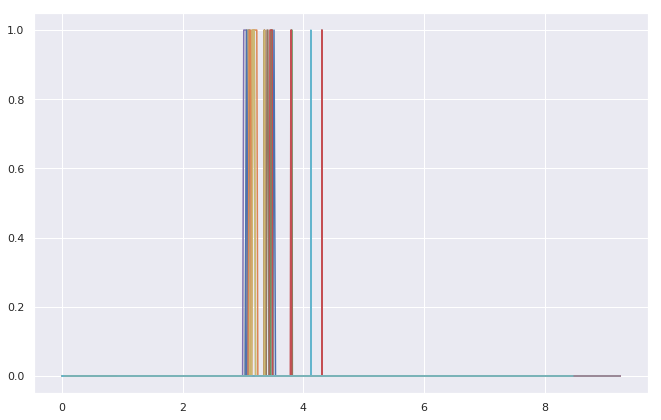

In [91]:
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33D1").glob('**/*.xls')
#path_in_str = str(pathlist)
for path in pathlist:
    path_in_str = str(path)

    df_test =pd.read_csv(path_in_str, delimiter='\t')
    df_test = df_test.loc[:, features]
    df_test.head()


    rolling_mean_acc = df_test['acceleration (actual) [m/(s*s)]'].rolling(roll_filter).mean()
    rolling_mean_tract_eff = df_test['tractive effort (actual) [kN]'].rolling(roll_filter).mean()
    rolling_mean = df_test['voltage [V]'].rolling(roll_filter).mean()
    distance = df_test['loc. (actual) [km]']

    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from sklearn.externals import joblib

    df = pd.DataFrame({
        'Voltage': rolling_mean,
        'Acceleration': rolling_mean_acc,
        "Location": distance,
        "Tract_effort": rolling_mean_tract_eff,
    })
    df = df.dropna()
    #df.plot()
    df = scaler.fit_transform(df)
    spliter = SequenceSpliter(lookback=LOOKBACK, look_ahead=LOOK_AHEAD)
    X, y = spliter.fit_transform(df)
    X = X[:, :, :]
    y = y[:, :, 0]
    #print(X.shape)
    #print(y.shape)

    #model = tf.keras.models.load_model("./models/anomaly_clfr.h5")
    #model.summary()

    preds = model.predict(X)

    plt.plot(distance[-len(preds):], np.argmax(preds, axis=1))